## Packages

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
 # Ensure project root (with src/) is on sys.path so imports like `from src...` work in notebooks
import sys
from pathlib import Path
p = Path.cwd()
for _ in range(6):
    if (p / 'pyproject.toml').exists():
        project_root = p
        break
    if p.parent == p:
        project_root = Path.cwd()
        break
    p = p.parent
else:
    project_root = Path.cwd()
# Insert at front so local src/ takes precedence
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
print(f'Added project root to sys.path: {project_root}')

Added project root to sys.path: c:\Users\jarno\Downloads\stock-predictor-1


## Input Parameters

In [3]:
ticker = "vusa.as"
start_date = "2019-01-01"
start_plot_date = "2025-01-01"
rsi_period = 14
periods = [20, 50, 200]
df = yf.download(ticker, start=start_date, interval="1d")
close_df = df[['Close']].copy()

C:\Users\jarno\AppData\Local\Temp\ipykernel_5688\3503777340.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, interval="1d")
[*********************100%***********************]  1 of 1 completed


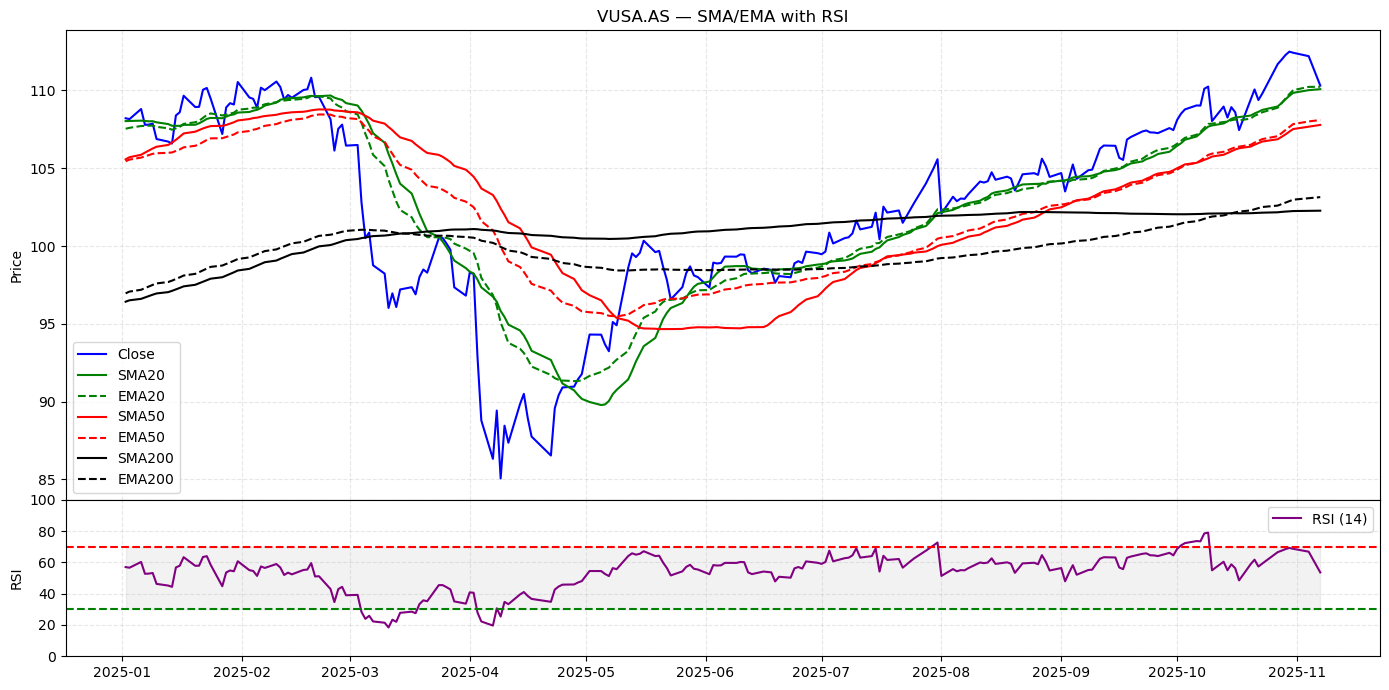

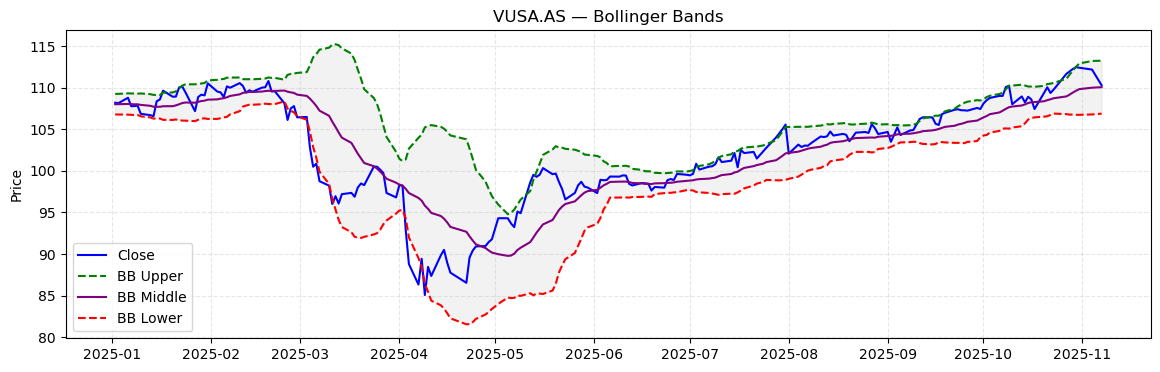

In [4]:
from src.plot_indicators import plot_sma_ema_with_rsi, plot_bollinger_bands, plot_rsi, plot_macd, plot_full_chart, plot_volume, plot_stochastic, plot_fibonacci_levels, plot_monthly_candles

plot_sma_ema_with_rsi(df, ticker, start_plot_date=start_plot_date)
plot_bollinger_bands(df, ticker, start_plot_date=start_plot_date)
# plot_rsi(df, ticker, start_plot_date=start_plot_date)
# plot_macd(df, ticker, start_plot_date=start_plot_date)

# plot_volume(df, ticker, start_plot_date=start_plot_date)
# plot_stochastic(df, ticker, start_plot_date=start_plot_date)
# plot_fibonacci_levels(df, ticker, start_plot_date=start_plot_date, auto_detect=True, lookback_period=150)


## SMA, EMA, BB printing

In [5]:
from src.technische_indicatoren import technische_indicatoren
technische_indicatoren(close_df, periods)

,,Value
Price,Ticker,
Close,VUSA.AS,110.315
SMA20,,110.082
SMA50,,107.784
SMA200,,102.271
EMA20,,110.236
EMA50,,108.098
EMA200,,103.143
BB_Upper,,113.270
BB_Middle,,110.082


## Summary output Technical analysis

In [6]:
from src.summary_analysis import summary_technical_indicators
summary_technical_indicators(ticker, df, rsi_period, periods, start_plot_date);

Analyse voor **VUSA.AS** (laatste datum: 2025-11-07):
- RSI (14): 53.59 → **Neutraal**
- Bollinger Bands: **Rond middenband (neutraal, consolidatie)**
- MACD (12,26,9): **Bullish (MACD boven signaallijn, koopsignaal)**
- SMA/EMA (20, 50, 200): **Sterk bullish (koers boven alle SMA/EMA)**



c:\Users\jarno\Downloads\stock-predictor-1\src\plot_indicators.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


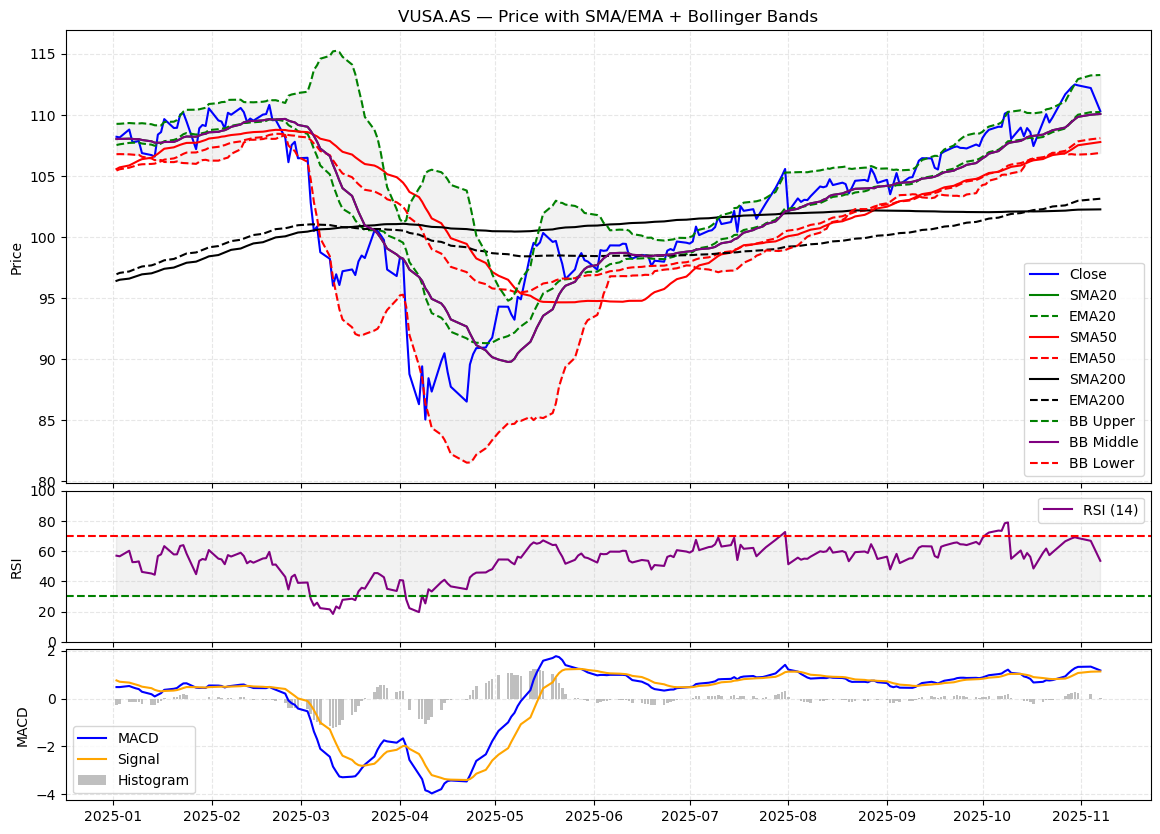

Plotted VUSA.AS with indicators: SMA: [20, 50, 200], EMA: [20, 50, 200], Bollinger Bands: period=20, std=2, RSI: period=14, MACD: fast=12, slow=26, signal=9


In [7]:
plot_full_chart(df, ticker, [20, 50, 200], start_plot_date, sma=True, ema=True);

## RSI predictor plot

Klik met de muis op de grafiek om een RSI-niveau te kiezen...


c:\Users\jarno\Downloads\stock-predictor-1\src\RSI_predictor.py:128: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  coords = plt.ginput(1)  # 1 klik


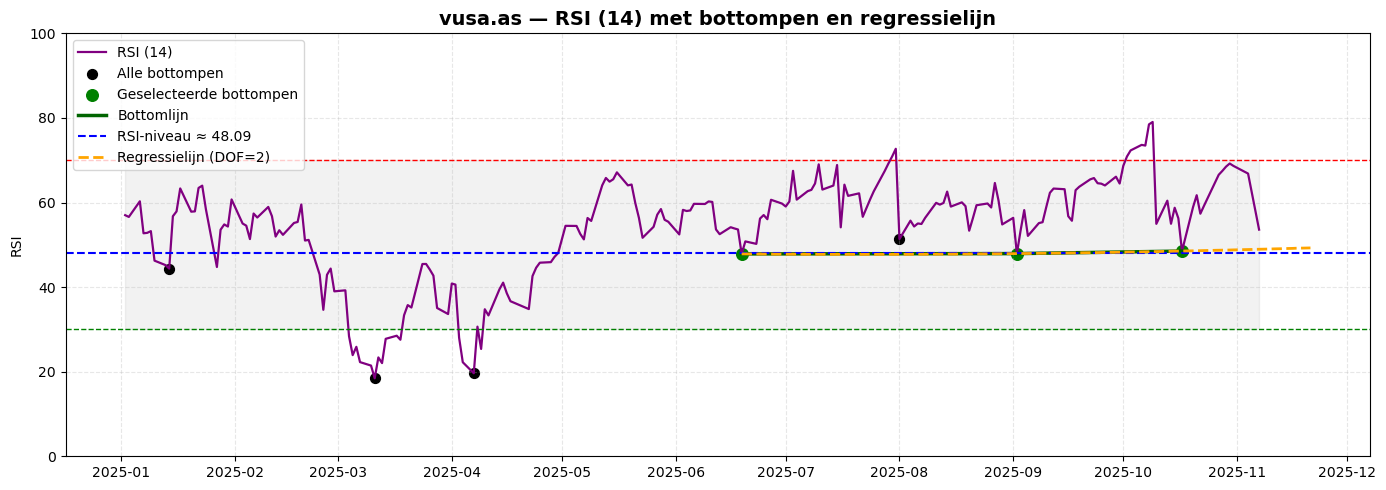

In [ ]:
# from src.RSI_predictor import plot_rsi_peaks

# plot_rsi_peaks(df, rsi_period, start_plot_date, ticker, 
#                mode='bottom', dof=1, future_days=135, selected_peak_indices=[3,5,6])

from importlib import reload
import src.RSI_predictor as rsi_mod

reload(rsi_mod)
rsi_mod.plot_rsi_peaks(df, rsi_period, start_plot_date, ticker, 
                       mode='bottom', dof=2, future_days=35, selected_peak_indices=[3, 5,6])




## Monthly candle

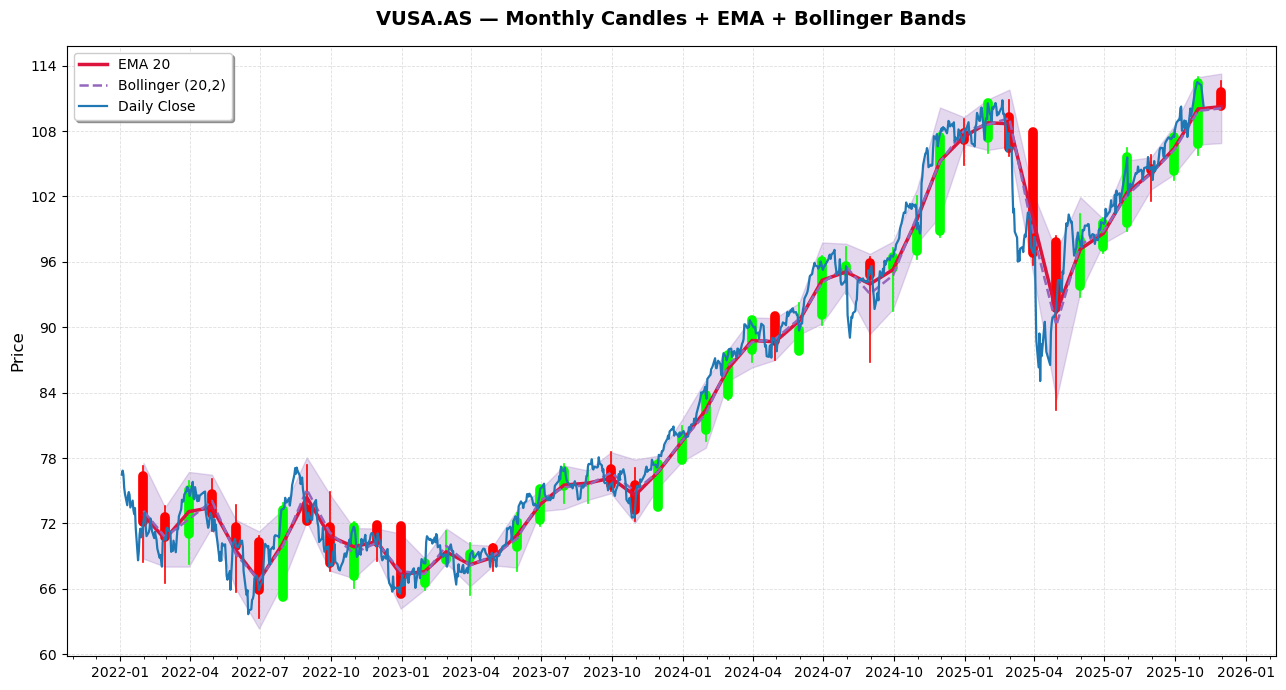

In [9]:
plot_monthly_candles(df, ticker, start_plot_date="2022-01-01")

## Rebound or trendswitch

In [10]:
from src.Bounce import scan_portfolio

List = ["nvda","hims","grrr","bzai","meta","bitf","iren","zeta","can","^gspc","vusa.as","fur.as","amg.as","gns"]

scan_result = scan_portfolio(
    tickers=List,
    start_date="2025-01-01"
)

Scanning 14 aandelen...


100%|██████████| 14/14 [00:02<00:00,  5.20it/s]


VOLLEDIGE SCANNER + MOMENTUM


,ticker,long_score,short_score,actie,momentum
0,ZETA,9,4,TE LAAT,RSI ↑ 55 | MACD ↑ -0.405 | Vol ↑ 125%
1,NVDA,6,0,KOOP VROEG,RSI ↓ 48 | MACD ↑ 4.678 | Vol ↑ 117%
2,BZAI,4,0,WACHT,RSI ↓ 38 | MACD ↓ -0.173 | Vol ↓ 53%
3,BITF,4,2,WACHT,RSI ↓ 46 | MACD ↓ 0.134 | Vol ↓ 52%
4,FUR.AS,4,0,WACHT,RSI ↓ 27 | MACD ↓ -0.283 | Vol ↓ 32%
5,VUSA.AS,2,0,NEUTRAAL,RSI ↑ 54 | MACD ↑ 1.184 | Vol ↓ 32%
6,HIMS,0,8,STERKE SHORT,RSI ↓ 35 | MACD ↓ -2.908 | Vol ↑ 140%
7,GRRR,0,3,NEUTRAAL,RSI ↓ 32 | MACD ↓ -0.934 | Vol ↓ 89%
8,META,0,0,NEUTRAAL,RSI ↓ 23 | MACD ↓ -24.379 | Vol ↑ 116%
9,IREN,0,10,STERKE SHORT,RSI ↑ 62 | MACD ↓ 4.545 | Vol ↑ 116%



                                   KOOPKANSEN                                   


,ticker,actie,long_details,momentum
1,NVDA,KOOP VROEG,Rebound | DB → BO @ 172.40,RSI ↓ 48 | MACD ↑ 4.678 | Vol ↑ 117%



                                 VERKOOPKANSEN                                  


,ticker,actie,short_details,momentum
6,HIMS,STERKE SHORT,Bearish Engulfing + RSI 34.5 | RSI Bear Div (-0.2),RSI ↓ 35 | MACD ↓ -2.908 | Vol ↑ 140%
9,IREN,STERKE SHORT,Shooting Star + RSI 62.2 | RSI Bear Div (-1.3) | DT (neck 63.30),RSI ↑ 62 | MACD ↓ 4.545 | Vol ↑ 116%
10,CAN,SHORT,Oversold | RSI Bear Div (-8.9),RSI ↓ 43 | MACD ↓ 0.015 | Vol ↓ 48%
11,^GSPC,SHORT,Oversold | RSI Bear Div (-0.0),RSI ↓ 48 | MACD ↓ 44.883 | Vol ↓ 65%
